In [17]:
using Plots
plotlyjs(dpi=300, display_type=:inline)
# pyplot(dpi=300)
# unicodeplots()
# theme(:dracula)
theme(:default)

In [54]:
function parseTiming(fname::String)::Real
    f = open(fname)
    for line in eachline(f)
        occursin("Braid", line) && continue
        occursin("wall time", line) && return parse(Float64, split(line)[end])
    end
    throw("Reached end of file!")
end

function parseTiming(fname::String, tol::Real)::Real
    f = open(fname)
    for line in eachline(f)
        occursin("Begin", line) && continue
        occursin("not available", line) && continue
        occursin("Solver Stats", line) && continue
        if occursin("Braid", line) && occursin("wall time", line)
            str = split(line)[6]
            res = parse(Float64, SubString(str, 1:length(str)-1))
            (res <= tol) && return parse(Float64, split(line)[end])
        end
    end
    throw("Reached end of file without satisfying tolerance! $(tol) Consider raising it.")
end

function parseIters(fname::String)::Integer
    f = open(fname)
    for line in eachline(f)
        occursin("max iterations", line) && continue
        occursin("iterations", line) && return parse(Int64, split(line)[end])
    end
end

println(parseTiming("ks_nc2_cf4_ml4", 1e-8))
println(parseTiming("ks_Delta2_nc2_cf4_ml4", 1e-8))

137.0
152.0


θ iters: 14
θ speedup: 1.6523254385964914 @ 512
Δ2 iters: 15
Δ2 speedup: 1.5397692098092643 @ 512
Δ4 iters: 14
Δ4 speedup: 1.6768406528189912 @ 256
Δ8 iters: 14
Δ8 speedup: 1.7659228125 @ 512
Δ16 iters: 13
Δ16 speedup: 1.5190733870967743 @ 512


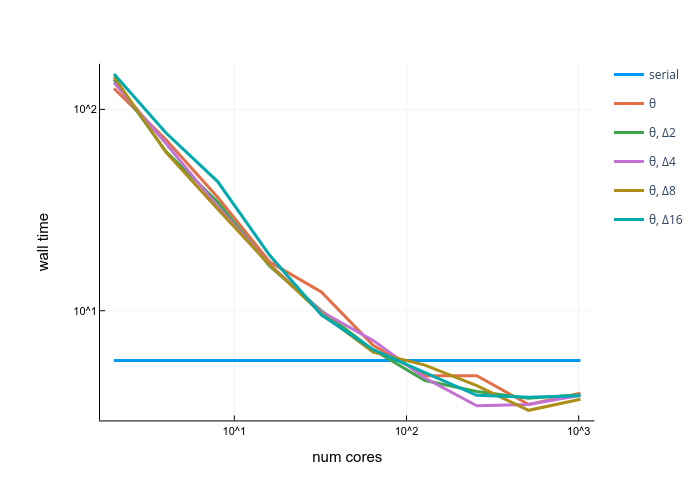

In [60]:

ncores = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
ranks = [2, 4, 8, 16]
ml = 4
cf = 4
tol = 1e-6

function readΔ(rank, nc) return parseTiming("ks_Delta$(rank)_nc$(nc)_cf$(cf)_ml$(ml)", tol) end
readθ = nc -> parseTiming("ks_nc$(nc)_cf$(cf)_ml$(ml)", tol)

# serial timing
tser = parseTiming("ks_ml1")
pl = plot(ncores, x->tser, linewidth=3, label="serial", xaxis=("num cores", :log), yaxis=("wall time", :log))

# θ timing
# tθ = zeros(length(ncores))
# for i in 1:length(ncores)
#     tθ[i] = parseTiming("ks_nc$(ncores[i])_cf$(cf)_ml$(ml)")
# end
itersθ = parseIters("ks_nc2_cf4_ml4")
tθ = readθ.(ncores)
println("θ iters: $(itersθ)")
println("θ speedup: $(tser/minimum(tθ)) @ $(ncores[argmin(tθ)])")
plot!(pl, ncores, tθ, linewidth=3, label="θ")

# Δ timings
for rank in ranks
    tΔ = zeros(length(ncores)) 
    itersΔ = parseIters("ks_Delta$(rank)_nc2_cf$(cf)_ml$(ml)")
    for i in 1:length(ncores)
        tΔ[i] = readΔ(rank, ncores[i])
    end
    println("Δ$(rank) iters: $(itersΔ)")
    println("Δ$(rank) speedup: $(tser/minimum(tΔ)) @ $(ncores[argmin(tΔ)])")
    plot!(pl, ncores, tΔ, linewidth=3, label="θ, Δ$(rank)")
end
savefig(pl, "scaling_cf$(cf)_ml$(ml).png")
plot!()

# println("fmg iters: $(itersfmg)")
# println("fmg speedup: $(tser/minimum(tfmg)) @ $(ncores[argmin(tfmg)])")

In [15]:
pl = plot(ncores, [tθ tΔ tfmg ],
          linewidth=3,
          dpi=200,
          label=["$(itersθ) iters: θ" "$(itersΔ) iters: θ, Δ" "$(itersfmg) iters: θ, Δ, fmg"],
          xaxis=("num cores", :log),
          yaxis=("wall time", :log),
)
plot!(pl, ncores, x->, linewidth=3, label="serial")
savefig(pl, "scaling_cf$(cf)_ml$(ml).png")
plot!()

UndefVarError: UndefVarError: itersΔ not defined

In [16]:
pl = plot(ncores, [tfmg/itersfmg tΔ/itersΔ tθ/itersθ],
          linewidth=3,
          dpi=200,
          label=["θ, Δ, fmg" "θ, Δ" "θ"],
          xaxis=("num cores", :log),
          yaxis=("wall time", :log),
)
plot!(pl, ncores, x->parseTiming("lorenz_theta_ml1"), linewidth=3, label="serial")
savefig(pl, "scaling_cf$(cf)_ml$(ml)_normalized.png")
plot!()

UndefVarError: UndefVarError: itersfmg not defined

In [6]:
parseTiming("lorenz_theta_ml1")

0.101741